In [1]:
from hypersurface import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D

In [2]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4
HS = Hypersurface(Z, f, 1000)

In [3]:
k = 3
HS.set_k(k)

Normalization factor of eta

In [4]:
# holomorphic=True by default
factor = (HS.integrate(lambda patch, point: patch.omega_omegabar(point), numerical=True) / \
          HS.integrate(lambda patch, point: patch.num_FS_volume_form('identity', point), numerical=True))

In [5]:
HS.integrate(lambda patch, point: patch.omega_omegabar(point), numerical=True)/HS.integrate(lambda patch, point: patch.num_FS_volume_form('identity', point), numerical=True, holomorphic=False)

0.08413021717250548

In [6]:
factor

0.0825943444225018

In [7]:
def get_h_matrix(HS, k):
    # Get the power of the coordinates
    sec, ns = HS.get_sections(k)
    h_diag = []
    for expr in sec:
        power = []
        for i in range(len(Z)):
            power.append(expr.diff(Z[i])*Z[i]/expr)
        h_diag.append(power)

    h_matrix = []
    h_params = np.zeros((ns, ns))
    # make a pair for each matrix element
    for i in range(len(h_diag)):
        h_matrix_row = []
        pz = h_diag[i]
        for j in range(len(h_diag)):
            pzbar = h_diag[j]
            if k >= len(Z):
                for l in range(len(Z)-1):
                    if (pz[l]-pzbar[l]-pz[l+1]+pzbar[l+1]) % 5 != 0:
                        h_matrix_row.append([])
                        break
                else:
                    h_matrix_row.append([pz,pzbar])
                    h_params[i][j] = -1
                    #if (pz!=pzbar):
                    #print( "non-diagonal", pz, pzbar )
            else:
                if i == j:
                    h_matrix_row.append([pz,pzbar])
                    h_params[i][j] = -1
                else:
                    h_matrix_row.append([])
                    
        h_matrix.append(h_matrix_row)                  
    #print( h_matrix[2][2] )
    
    h_type = []
    param = 1
    for i in range(ns):
        for j in range(ns):
            if h_params[i][j] > -1:
                continue
            for m in range(i, ns):
                for n in range(ns):
                    if h_params[m][n] > -1:
                        continue
                    if sorted(h_matrix[m][n][0]) == sorted(h_matrix[i][j][0]):
                        for perm in itertools.permutations(range(5)):
                            if h_matrix[i][j] == [[h_matrix[m][n][0][p] for p in perm],[h_matrix[m][n][1][p] for p in perm]]:
                                h_params[m][n] = param
                                h_params[n][m] = param
                                break
            param += 1
            if i == 1 and j == 1:
                continue
            else:
                h_type.append(i!=j)
            
    return (h_params,h_type)

In [8]:
(h_sym,h_complex) = get_h_matrix(HS, k)
print(h_complex)

[False, False]


Reconstruct h matrix from the parameters

In [9]:
def number_of_real_parameters(h_complex):
    return sum([2 if x else 1 for x in h_complex])

In [10]:
def param_to_matrix(param):
    h_matrix = np.array(h_sym,dtype='complex')
    i_cpx = len(h_complex)
    for i in range(len(h_complex)):
         if not h_complex[i]:
            x = exp(param[i])
            for m in range(len(h_sym)):
                if h_sym[m][m] == i+2:
                    h_matrix[m][m] = x
    for i in range(len(h_complex)):
        if h_complex[i]:
            x = complex(param[i],param[i_cpx])
            for m in range(len(h_sym)):
                for n in range(m,len(h_sym)):
                    if h_sym[m][n] == i+2:
                        # these should all be related by symmetry - check?
                        xn = x * sqrt(h_matrix[m][m]*h_matrix[n][n])
                        h_matrix[m][n] = xn
                        h_matrix[n][m] = np.conj(xn)
            i_cpx += 1
    return h_matrix

In [11]:
def integration(param): 
    h = param_to_matrix(param)
    #h = np.matmul(g, np.conj(g.transpose()))
    
    integration = HS.integrate(lambda patch, point, h_matrix=h: 
                                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                                holomorphic=False, numerical=True)
    integration = integration.real
    print(HS.integrate(lambda patch, point: patch.num_FS_volume_form(h, point)/patch.num_FS_volume_form('identity', point), numerical=True))
    print(integration)
    print(param)
    try:
        np.linalg.cholesky(h)
    except:
        print("Not positive definite")
    return integration

Set an initial condition

In [12]:
g0 = np.zeros(number_of_real_parameters(h_complex))

In [13]:
g0

array([0., 0.])

In [14]:
param_to_matrix(g0)

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]])

In [15]:
#res = minimize(integration, g0, method='L-BFGS-B', options={'iprint':1, 'ftol': 1e-04, 'eps': 1e-02, 'maxiter':20})
res = minimize(integration, g0, method='L-BFGS-B', options={'ftol': 1e-06, 'maxiter':200})

1.0
0.241872955396084
[0. 0.]
0.9999999997890621
0.2418729558535961
[1.e-08 0.e+00]
0.9999999999883133
0.2418729566338709
[0.e+00 1.e-08]
1.007286831228086
0.2976809792853867
[-0.34669623 -0.93797747]
1.0072868310209628
0.2976809782744348
[-0.34669622 -0.93797747]
1.0072868312388343
0.29768097818712613
[-0.34669623 -0.93797746]
1.0021263259975948
0.22472130180211444
[-0.09084264 -0.24577236]
1.002126325783004
0.2247213018815281
[-0.09084263 -0.24577236]
1.00212632599354
0.22472130170778612
[-0.09084264 -0.24577235]
1.0024335194819405
0.22446831046396262
[-0.1054834  -0.22962902]
1.002433519267324
0.22446831056027472
[-0.10548339 -0.22962902]
1.0024335194773093
0.22446831040737233
[-0.1054834  -0.22962901]
1.0071104265928266
0.22478617705692341
[-0.33083206 -0.067149  ]
1.0071104263810462
0.22478617717574018
[-0.33083205 -0.067149  ]
1.0071104265792514
0.22478617758850516
[-0.33083206 -0.06714899]
1.0047498474078727
0.22357046793521473
[-0.21584211 -0.15005861]
1.0047498471937728
0.2235

In [16]:
print(res.x)

[-0.30022743 -0.14244655]


In [17]:
h_minimal = param_to_matrix(res.x)

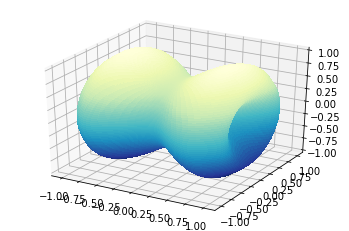

In [18]:
#param = [-0.2]
#h_minimal = param_to_matrix(param)
#h_minimal = 'identity'
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.001,np.pi+0.001, 100), np.linspace(0.001, 2*np.pi+0.001, 100)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, complex(t), 0, -complex(t)])*factor
            #print('test',np.absolute(t**4))
            #print(patch.restriction([1, -1, complex(t), 0, -complex(t)]))
            #print("t<=1", t)
        else:
            #eta = 0
            eta = patch.num_eta(h_minimal, [1, -1, complex(1/t), 0, -complex(1/t)])*factor
  
            #print('test',np.absolute(t**4), 1/t**4)
        theta_list.append(float(eta))
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
#ax.set_xlim3d(-0.8, 0.8)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)


Standard deviation of eta:

In [19]:
sum_eta_sq = 0
mean_abs_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            eta = sum_eta = 0
mean_abs_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            eta = subpatch.num_eta(h_minimal, point)
            sum_eta_sq += (eta*factor - 1)**2
            mean_abs_eta += abs(eta*factor - 1)
print(math.sqrt((sum_eta_sq-mean_abs_eta**2/HS.n_points)/(HS.n_points - 1)))

0.22823507346851502


In [26]:
sigma = HS.integrate(lambda patch, point, h_matrix=h_minimal: 
                         np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                         holomorphic=True, numerical=True)

In [21]:
delta_sigma = math.sqrt(HS.integrate(lambda patch, point, h_matrix=h_minimal: 
                         (np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real - sigma)**2, 
                         holomorphic=True, numerical=True)/HS.n_points)

In [22]:
print(delta_sigma)

0.0029324214766979916


In [27]:
print(sigma)

0.22361954625721045
